### Explanation of the Script

- **Intended Use**: This script is designed to process and analyze benchmark results stored in multiple `summary.json` files. It extracts key metrics related to the performance of large language models (LLMs) and generates visualizations to help users interpret the results.
  
- **Setup**: 
  - Specify the directory where your benchmark results are located by updating the `benchmark_dir` variable.
  - The script will automatically search for all `summary.json` files within this directory (and subdirectories).

- **Data Extraction**: 
  - The script will read each `summary.json` file, extracting key metrics such as:
    - Inter-Token Latency (P90)
    - Time to First Token (TTFT) Latency (P90)
    - End-to-End Latency (P90)
    - Request Output Throughput (P90)
    - Mean Output Throughput
    - **Concurrent Requests**: The number of concurrent requests made during the benchmark run.
  - These metrics are stored in a pandas DataFrame for further analysis.

- **Data Visualization**:
  - The script generates plots showing how these metrics change based on the number of concurrent requests.
  - Each plot compares different token combinations (input/output) across concurrent requests.
  - It uses different colors, markers, and line styles for easy distinction between token combinations.
  
- **Saving Results**:
  - Plots are automatically saved as images in the `plots` directory inside the benchmark folder.
  - The aggregated data from the summary files is saved into a CSV file (`aggregated_results.csv`) for further analysis.

- **Error Handling**: 
  - The script includes basic error handling to manage issues like missing files or incorrect JSON formats, ensuring the process continues without crashing.


Benchmark results directory set to: llmperf/vllm_bench_results/zoom-tp8-b8/
Plots will be saved to: llmperf/vllm_bench_results/zoom-tp8-b8/plots
Found 9 summary files.
Plot saved to: llmperf/vllm_bench_results/zoom-tp8-b8/plots/results_inter_token_latency_s_quantiles_p90_vs_concurrent_requests.png


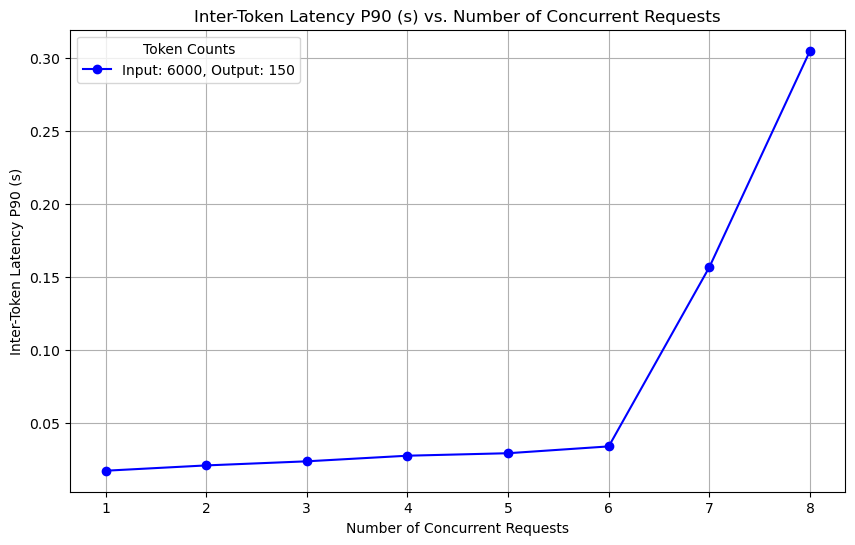

Plot saved to: llmperf/vllm_bench_results/zoom-tp8-b8/plots/results_ttft_s_quantiles_p90_vs_concurrent_requests.png


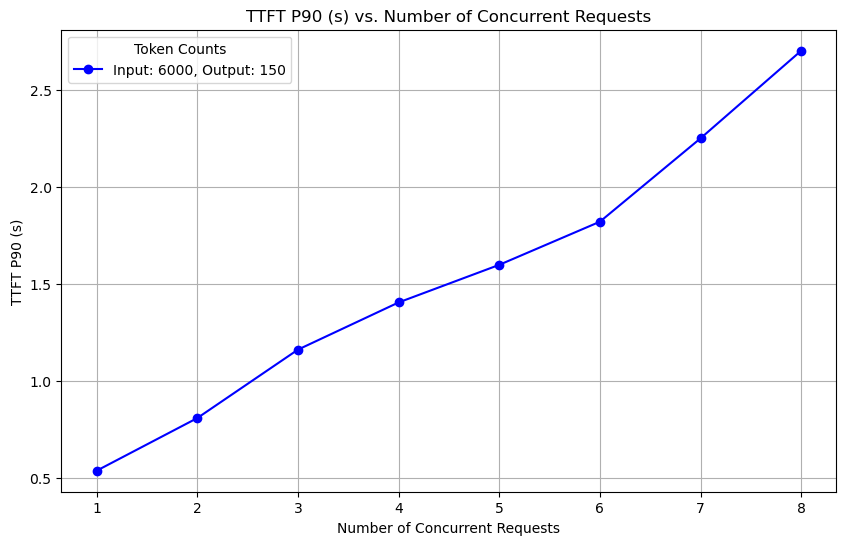

Plot saved to: llmperf/vllm_bench_results/zoom-tp8-b8/plots/results_end_to_end_latency_s_quantiles_p90_vs_concurrent_requests.png


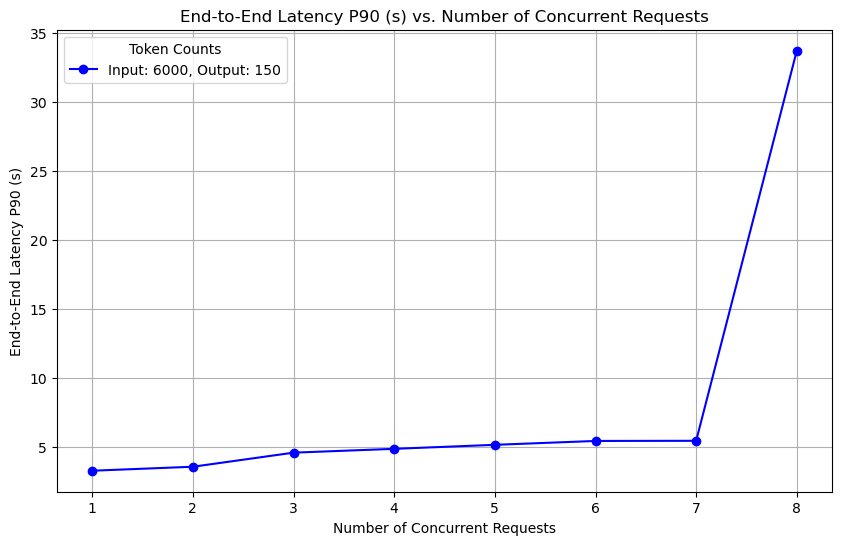

Plot saved to: llmperf/vllm_bench_results/zoom-tp8-b8/plots/results_request_output_throughput_token_per_s_quantiles_p90_vs_concurrent_requests.png


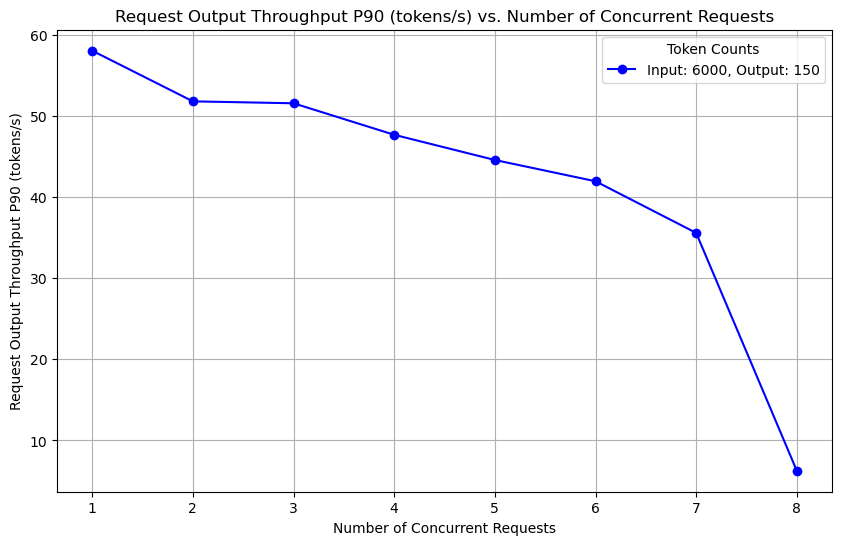

Plot saved to: llmperf/vllm_bench_results/zoom-tp8-b8/plots/results_mean_output_throughput_token_per_s_vs_concurrent_requests.png


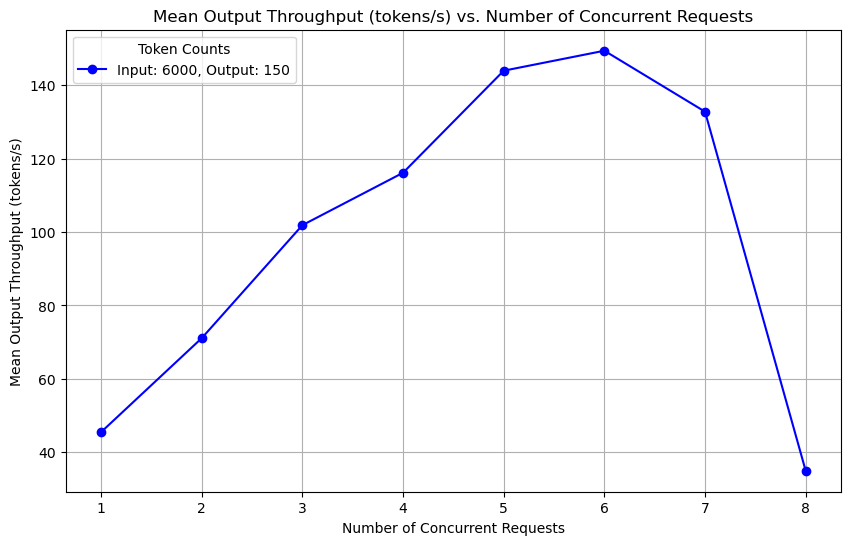

Aggregated data saved to llmperf/vllm_bench_results/zoom-tp8-b8/aggregated_results.csv


In [1]:
benchmark_dir = 'llmperf/vllm_bench_results/zoom-tp8-b8/'

# Install necessary libraries
!pip install pandas matplotlib

# Import necessary libraries
import os
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Validate the directory
if not os.path.exists(benchmark_dir):
    print(f"The directory {benchmark_dir} does not exist. Please check the path and try again.")
else:
    print(f"Benchmark results directory set to: {benchmark_dir}")

    # Option to save plots
    save_plots = True  # Set to False if you don't want to save the plots as images

    # Create a directory to save plots if it doesn't exist
    plots_dir = os.path.join(benchmark_dir, 'plots')
    if save_plots:
        os.makedirs(plots_dir, exist_ok=True)
        print(f"Plots will be saved to: {plots_dir}")

    # Search for summary.json files
    summary_files = glob.glob(os.path.join(benchmark_dir, '**', '*summary.json'), recursive=True)

    print(f"Found {len(summary_files)} summary files.")

    # Initialize a list to store data
    data_list = []

    # Extract data from each summary file
    for summary_file in summary_files:
        try:
            with open(summary_file, 'r') as f:
                summary_data = json.load(f)

                data = {
                    'mean_input_tokens': summary_data.get('mean_input_tokens'),
                    'mean_output_tokens': summary_data.get('mean_output_tokens'),
                    'num_concurrent_requests': summary_data.get('num_concurrent_requests'),
                    'results_inter_token_latency_s_quantiles_p90': summary_data.get('results_inter_token_latency_s_quantiles_p90'),
                    'results_ttft_s_quantiles_p90': summary_data.get('results_ttft_s_quantiles_p90'),
                    'results_end_to_end_latency_s_quantiles_p90': summary_data.get('results_end_to_end_latency_s_quantiles_p90'),
                    'results_request_output_throughput_token_per_s_quantiles_p90': summary_data.get('results_request_output_throughput_token_per_s_quantiles_p90'),
                    'results_mean_output_throughput_token_per_s': summary_data.get('results_mean_output_throughput_token_per_s')
                }

                data_list.append(data)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON from file {summary_file}: {e}")
        except Exception as e:
            print(f"An error occurred while processing file {summary_file}: {e}")

    # Create a DataFrame
    df = pd.DataFrame(data_list)

    # Define numeric columns
    numeric_columns = [
        'mean_input_tokens',
        'mean_output_tokens',
        'num_concurrent_requests',
        'results_inter_token_latency_s_quantiles_p90',
        'results_ttft_s_quantiles_p90',
        'results_end_to_end_latency_s_quantiles_p90',
        'results_request_output_throughput_token_per_s_quantiles_p90',
        'results_mean_output_throughput_token_per_s'
    ]

    # Convert columns to numeric types
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

    # Drop rows with NaN values in key metrics
    df = df.dropna(subset=['mean_input_tokens', 'mean_output_tokens', 'num_concurrent_requests'])

    # Sort the DataFrame
    df = df.sort_values(['mean_input_tokens', 'mean_output_tokens', 'num_concurrent_requests'])
    df.reset_index(drop=True, inplace=True)

    # Aggregate data if necessary
    aggregated_df = df.groupby(
        ['mean_input_tokens', 'mean_output_tokens', 'num_concurrent_requests'],
        as_index=False
    ).mean()

    # Get unique token combinations
    token_combinations = aggregated_df[['mean_input_tokens', 'mean_output_tokens']].drop_duplicates()

    # Define the metrics to plot
    metrics = {
        'results_inter_token_latency_s_quantiles_p90': {
            'ylabel': 'Inter-Token Latency P90 (s)'
        },
        'results_ttft_s_quantiles_p90': {
            'ylabel': 'TTFT P90 (s)'
        },
        'results_end_to_end_latency_s_quantiles_p90': {
            'ylabel': 'End-to-End Latency P90 (s)'
        },
        'results_request_output_throughput_token_per_s_quantiles_p90': {
            'ylabel': 'Request Output Throughput P90 (tokens/s)'
        },
        'results_mean_output_throughput_token_per_s': {
            'ylabel': 'Mean Output Throughput (tokens/s)'
        }
    }

    # Define colors, markers, and line styles
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta', 'black', 'brown']
    markers = ['o', 's', '^', 'D', 'v', '*', 'P', 'X', 'h']
    line_styles = ['-', '--', '-.', ':']

    # Loop over each metric to plot
    for metric, info in metrics.items():
        ylabel = info['ylabel']
        plt.figure(figsize=(10, 6))
        for idx, (_, row) in enumerate(token_combinations.iterrows()):
            input_tokens = row['mean_input_tokens']
            output_tokens = row['mean_output_tokens']
            subset = aggregated_df[
                (aggregated_df['mean_input_tokens'] == input_tokens) &
                (aggregated_df['mean_output_tokens'] == output_tokens)
            ].sort_values('num_concurrent_requests')
            if subset.empty:
                continue
            color = colors[idx % len(colors)]
            marker = markers[idx % len(markers)]
            line_style = line_styles[idx % len(line_styles)]
            plt.plot(
                subset['num_concurrent_requests'],
                subset[metric],
                marker=marker,
                color=color,
                linestyle=line_style,
                label=f"Input: {input_tokens}, Output: {output_tokens}"
            )
        plt.title(f'{ylabel} vs. Number of Concurrent Requests')
        plt.xlabel('Number of Concurrent Requests')
        plt.ylabel(ylabel)
        plt.xticks(sorted(aggregated_df['num_concurrent_requests'].unique()))
        plt.legend(title='Token Counts')
        plt.grid(True)
        if save_plots:
            # Construct a safe filename
            safe_metric_name = metric.replace(' ', '_').replace('/', '_per_')
            plot_filename = f"{safe_metric_name}_vs_concurrent_requests.png"
            plot_path = os.path.join(plots_dir, plot_filename)
            plt.savefig(plot_path)
            print(f"Plot saved to: {plot_path}")
        plt.show()

    # Optional: Save aggregated data to CSV
    output_csv = os.path.join(benchmark_dir, 'aggregated_results.csv')
    aggregated_df.to_csv(output_csv, index=False)
    print(f"Aggregated data saved to {output_csv}")
